In [4]:
LOCAL=False
import os
import importlib

if LOCAL:
    path = '/Users/berk/Documents/research/nna/src/scripts/'
else:
    path = '/home/enis/projects/nna/src/scripts/'
os.chdir(path)

import teacher
from nna import weather

# import itertools
import pandas as pd

import numpy as np
import random


Output(layout=Layout(border='1px solid black'))

In [24]:
importlib.reload(teacher)
importlib.reload(weather)

version_tag='weather_V3'
dataset_version='W3'

FILE_PER_LOCATION=1
TIMESTAMPS_PER_ROW = 4

config = teacher.setup(versiontag=version_tag)

if LOCAL:
    weather_data_folder='/Users/berk/Downloads/NNA_files/weather_data/2017_2020'
else:
    weather_data_folder='/scratch/enis/data/nna/weather_data/2017_2020'

root_path = '/scratch/enis/data/nna/labeling/samples'
config['split_out_path'] = f'{root_path}/{version_tag}/audio_'

## data-1: as many sampes as possible
config['new_dataset_path'] = f'{root_path}/{version_tag}/{version_tag}.csv'
config['dataset_version'] = dataset_version
# config['versiontag'] = 'yfitloiq-V1'
config['excell_label_headers']=['day_length','air_temp','snow_depth',
        'cloud_fraction','relative_humidity','runoff','rain_precip',
         'snow_precip','wind_direction','wind_speed']

# config['excell_label_headers']=['day_length','air_temp','snow_depth',
#         'cloud_fraction','relative_humidity','runoff','rain_precip',
#          'snow_precip','wind_direction','wind_speed',
#         'snow_blowing_ground','snow_blowing_air',]


config['upper_taxo_links']={}


# print('total sample count to be produced:',file_per_location*len(short_ones.keys()))

# 40 Prudhoe or ANWR monitoring sites AND the Ivvavik sites
short_input_csv_headers = ['day_length','air_temp','snow_depth',
        'cloud_fraction','relative_humidity','runoff','rain_precip',
         'snow_precip','wind_direction','wind_speed']
# (year,month,day,hour,day_length,air_temp,snow_depth,
#                 cloud_fraction,relative_humidity,runoff,rain_precip,
#                     snow_precip,wind_direction,wind_speed)=row
# for Dalton and Dempster
long_input_csv_headers = ['day_length','air_temp','snow_depth',
        'cloud_fraction','relative_humidity','runoff','rain_precip',
         'snow_precip','total_precip','wind_direction','wind_speed',
        'snow_blowing_ground','snow_blowing_air']

excell_all_headers = [
    'data_version', 'Annotator', 'Site ID', 'File Name', 'Date', 'Start Time',
    'End Time', 'Length', 'Clip Path', 'Comments', 'weather_timestamp',
    'region', 'day_length', 'air_temp', 'snow_depth', 'cloud_fraction',
    'relative_humidity', 'runoff', 'rain_precip','rain_precip_mm', 'snow_precip',
    'wind_direction', 'wind_speed'
]

# (year,month,day,hour,day_length,air_temp,snow_depth,
# cloud_fraction,relative_humidity,runoff,rain_precip,
# snow_precip,total_precip,wind_direction,wind_speed,
# snow_blowing_ground,snow_blowing_air)=row

short_locations=('prudhoe','ivvavik','anwr')
long_locations=('dalton','dempster')

if LOCAL:
    file_database = '/Users/berk/Documents/scratch/enis/data/nna/database/allFields_dataV10.pkl'
else:
    file_database = '/scratch/enis/data/nna/database/allFields_dataV10.pkl'

In [6]:

def get_weather_rows(region, location, file_properties_df, fname,
                     short_locations, long_locations, short_input_csv_headers,
                     long_input_csv_headers, file_per_location):

    filtered_files = file_properties_df[file_properties_df['region'] == region]
    filtered_files = filtered_files[filtered_files['locationId'] == location]

    weather_data = weather.load_weather_data(region, location, fname, short_locations,
                                     long_locations, short_input_csv_headers,
                                     long_input_csv_headers)

    # Find the earliest start and end timestamps in weather_data
    earliest_start = weather_data['TIMESTAMP'].min()
    earliest_end = weather_data['TIMESTAMP'].max()

    # Filter the rows of filtered_files dataframe
    filtered_files = filtered_files[
        (filtered_files['timestamp'] >= earliest_start) &
        (filtered_files['timestampEnd'] <= earliest_end)]

    # Check if filtered_files is empty
    if filtered_files.empty:
        print('No matching files found!')
    else:
        weather_rows =weather.get_weather_rows(filtered_files, weather_data,
                                        file_per_location)
        buffer_seconds = 0

        new_dataset_csv, not_found_rows = teacher.generate_new_dataset(
            weather_rows,
            config['versiontag'],
            config['split_out_path'],
            file_properties_df,
            config['upper_taxo_links'],
            config['dataset_version'],
            buffer=buffer_seconds,
            excell_label_headers={},  #config['excell_label_headers'],
            labels_thresholds={},  #config['labels_thresholds'],
            outputSuffix='.wav',
            dry_run=False,
            excell_labels_2_names={},  #config['excell_labels_2_names'],
            stereo2mono=True,
            overwrite=False,
            sampling_rate=48000,
            label_row_by_threshold=False,
            print_logs=False,
        )
        assert len(new_dataset_csv) == len(weather_rows), 'len(new_dataset_csv) != len(weather_rows)'
        return new_dataset_csv, not_found_rows, weather_rows

    return [], [], pd.DataFrame()

In [15]:
file_properties_df = pd.read_pickle(file_database)
station_csv = weather.csv_path_per_regloc(weather_data_folder)
station_years = weather.year_per_regloc(station_csv,file_properties_df)
file_per_location=FILE_PER_LOCATION
new_dataset_csv, not_found_rows = [], []
df_per_location=[]
for (region, location),fname in station_csv.items():
    if (region,location) != ('dempster', '19'):
        continue
    print('region:',region,'location:',location,'fname:',fname)
    new_dataset, not_found, weather_rows =get_weather_rows(region, location, file_properties_df, fname,
                        short_locations, long_locations, short_input_csv_headers,
                        long_input_csv_headers, file_per_location)

    new_dataset_df=pd.DataFrame(new_dataset).reset_index(drop=True)
    weather_rows_df=weather_rows.reset_index(drop=True)
    combined=pd.concat([new_dataset_df, weather_rows_df], axis=1)
    df_per_location.append(combined)
    assert len(not_found)==0, 'not_found is not empty'

dataset=pd.concat(df_per_location)


region: dempster location: 19 fname: /scratch/enis/data/nna/weather_data/2017_2020/Dempster/sm_products_by_station/sm_data_stn_08_Dempster19.csv


In [23]:
dataset.columns

Index(['data_version', 'Annotator', 'Site ID', 'File Name', 'Start Time',
       'End Time', 'Date', 'Length', 'Clip Path', 'Comments', 'location',
       'region', 'TIMESTAMP', 'day_length', 'air_temp', 'snow_depth',
       'cloud_fraction', 'relative_humidity', 'runoff', 'rain_precip',
       'snow_precip', 'total_precip', 'wind_direction', 'wind_speed',
       'snow_blowing_ground', 'snow_blowing_air', 'rain_precip_mm',
       'timestamp_start', 'timestamp_end', 'timestamp_orig_weather',
       'weather_timestamp'],
      dtype='object')

In [25]:
assert dataset['Clip Path'].unique().shape[0]==dataset.shape[0], 'Clip Path is not unique'
dataset['weather_timestamp']=dataset['timestamp_orig_weather']
dataset[excell_all_headers].to_csv(config['new_dataset_path'],index=False, header=True, )

In [22]:
dataset['Clip Path'].unique().shape[0],dataset.shape[0]

(14800, 14800)

In [12]:
dataset=dataset.drop_duplicates(subset=['Clip Path'])

In [13]:
# dataset_copy=dataset.copy()
# dataset=pd.concat([dataset,dataset_copy])

In [29]:
dataset[['rain_precip','rain_precip_mm']]

,rain_precip,rain_precip_mm
0,0.000000,0.000000
0,0.000418,0.418094
1,0.000045,0.045358
2,0.000000,0.000000
3,0.000007,0.007408
...,...,...
195,0.000000,0.000000
196,0.000000,0.000000
197,0.000000,0.000000
198,0.000325,0.324959


In [35]:
dataset['timestamp_orig_weather'].unique().shape[0],dataset.shape[0]

(2483, 14800)

<AxesSubplot:>

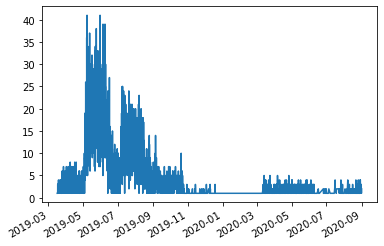

In [39]:
dataset['timestamp_orig_weather'].value_counts().plot()

In [1]:
%matplotlib inline